In [10]:
import os
import cv2
import math
import torch
import pickle
import random
import imutils
import numpy as np
import onnxruntime
import pandas as pd
from typing import Any
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Loads the spreadsheet

In [11]:
# get smoky-mountain-data-comp folder
HOME_DIR = str(Path().cwd().parent)

# load the spreadsheet into the kernel
SHEET_DATA = pd.read_excel(f"{HOME_DIR}/data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Type Declarations and Helpful Functions

In [12]:
cv2.Image = np.ndarray
cv2.BinaryImage = np.ndarray
cv2.Contour = np.ndarray
Mask = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get all the contours
def get_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    return cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# get contours that are optimized by the area - to - boudning rect metric, with large contours favored
def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

# display filename and image, and get image going to filename
def get_image(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"{HOME_DIR}/dataset/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

# draw the contours onto the image
def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        if mode == "random":
            color = tuple(random.randint(150, 255) for _ in range(3))
        elif mode == "red": 
            color = (0, 0, 255)
        elif mode == "blue":
            color = (255, 0, 0)
        elif mode == "green":
            color = (0, 255, 0)
        else:
            raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

## Segment the leaves from the image

### Approach 1: Use large contours and an image mask

4E2D558B-EC3C-425D-BEF8-0AAE9966972A.jpg


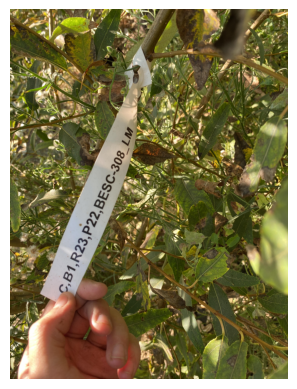

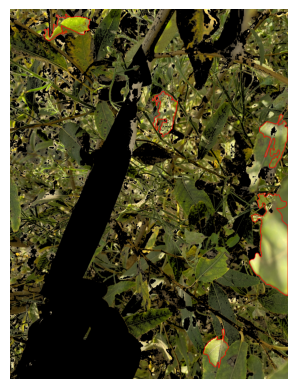

In [13]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(get_contours(masked, False), n=5)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

img = get_image()
get_leaves(img, debug=True)

This is not good - very inaccurate and unreliable

### Approach 2: Use Canny Edge detection and image inflation to detect contours

5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg


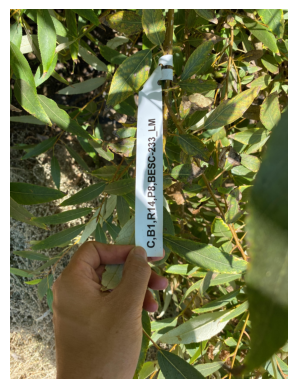

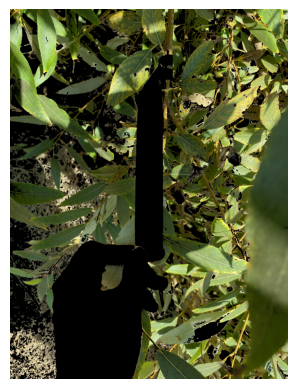

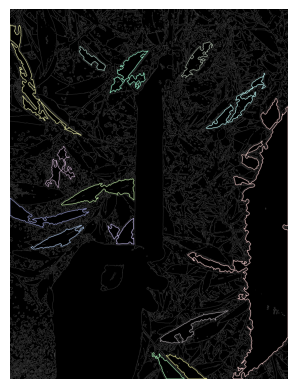

In [14]:
def patchify(img: cv2.BinaryImage, n: int, iters: int) -> Any:
    assert n % 2, "Side length must be odd"
    """ Outputs a square of points around the center (0, 0) with corners removed. """
    new_img = img.copy()
    for _ in range(iters):
        diff = n // 2
        kernel = np.ones((n, n), dtype=np.uint8)
        for y in range(-diff, diff+1):
            for x in range(-diff, diff+1):
                if abs(y) + abs(x) > diff + 1:
                    kernel[y+diff][x+diff] = 0
        new_img = cv2.dilate(new_img, kernel)
    return new_img

def filter_contours(contours: list[cv2.Contour], mask: cv2.BinaryImage) -> list[cv2.Contour]:
    l1, l2 = mask.shape[:2]
    contours = [i[0] for i in filter(
        lambda b: l1 // 16 < b[1][1] and l2 // 16 < b[1][0],
        [(cnt, cv2.boundingRect(cnt)[2:]) for cnt in contours]
    )]
    green_colored_contours = []
    for contour in contours: 
        mask_inside_contour = np.zeros_like(mask, np.uint8)
        mask_inside_contour = cv2.drawContours(mask_inside_contour, [contour], -1, 255, -1)
        mean = cv2.mean(mask, mask=mask_inside_contour)
        if mean[0] >= 100:
            green_colored_contours.append(contour)
    contours = get_optimized_contours(green_colored_contours, 15)
    return contours

def get_leaf_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:

    # generate a mask for the image (colors we are interested in)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 50, 50), (80, 255, 255))
    masked = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
    if debug: imshow(cv2.cvtColor(masked, cv2.COLOR_HSV2BGR))

    # find the edges using the Canny algorithm
    img_blur = cv2.GaussianBlur(masked, (23, 23), sigmaX=0, sigmaY=0) 
    edges = cv2.Canny(img_blur, threshold1=20, threshold2=40)
    dilated = cv2.bitwise_not(patchify(edges, 13, iters=2))

    # find the contours in the resulting image to determine which ones are leaves
    contours = filter_contours(cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], mask)

    # display found leaves
    if debug:
        drawn_contours = draw_contours(contours, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR))
        imshow(drawn_contours)

    return contours

img = get_image('5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg')
_ = get_leaf_contours(img, debug=True)

Download and use Segmant Anything Model for segmenting knowing the leaf point

In [8]:
# const information
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_h"
SAM_MODEL_NAME = "sam_vit_h_4b8939.pth"
SAM_PATH = "seg_from_SAM"
SAM_DATA_PATH = "seg_from_SAM/images"
ONNX_MODEL_NAME = "onnx_model.onnx"

# checks for the model being downloaded
if SAM_MODEL_NAME not in os.listdir():
    os.system(f"wget https://dl.fbaipublicfiles.com/segment_anything/{SAM_MODEL_NAME}")

if ONNX_MODEL_NAME not in os.listdir():
    os.system("python3 load_onnx_model.py")

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_MODEL_NAME)

sh: wget: command not found
sh: ./scripts/SAM.sh: No such file or directory
Traceback (most recent call last):
  File "/Users/l41/Documents/smoky-mountain-data-comp/step2/load_onnx_model.py", line 25, in <module>
    sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_MODEL_NAME)
  File "/Users/l41/Documents/smoky-mountain-data-comp/.venv/lib/python3.9/site-packages/segment_anything/build_sam.py", line 15, in build_sam_vit_h
    return _build_sam(
  File "/Users/l41/Documents/smoky-mountain-data-comp/.venv/lib/python3.9/site-packages/segment_anything/build_sam.py", line 104, in _build_sam
    with open(checkpoint, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'sam_vit_h_4b8939.pth'


FileNotFoundError: [Errno 2] No such file or directory: 'sam_vit_h_4b8939.pth'

Start an ONNX runtime session for segmentation

In [ ]:
ort_session = onnxruntime.InferenceSession(ONNX_MODEL_NAME)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg


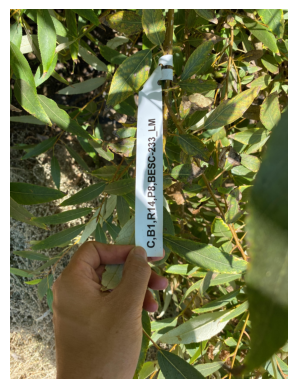

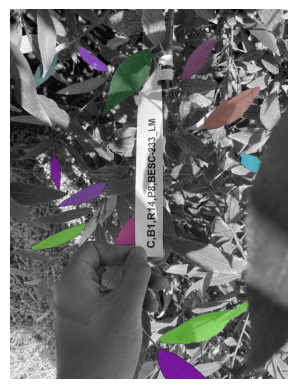

In [ ]:
def is_valid(mask: np.array, img: cv2.Image) -> bool:

    GREEN_LOWER = np.array([20, 50, 50])
    GREEN_UPPER = np.array([80, 255, 255])
    AREA_THRESH = 8

    # make sure mask doesnt take up too much of the image
    h, w = img.shape[:2]
    if mask.sum() > h * w // AREA_THRESH:    
        return False
    
    # make sure mean color is greenish 
    mean = cv2.mean(cv2.cvtColor(img, cv2.COLOR_BGR2HSV), mask=mask.astype(np.uint8))
    if not all([
        lower < col < upper for lower, col, upper
        in zip(GREEN_LOWER, mean, GREEN_UPPER)
    ]):
        return False
    
    return True

def get_masks(img: cv2.Image, predictor: SamPredictor, 
              ort_session: onnxruntime.InferenceSession, show: bool = False) -> list[Mask]:
    
    # encode the images
    predictor.set_image(img)
    image_embedding = predictor.get_image_embedding().cpu().numpy()

    input_points, masks = [], []
    for contour in get_leaf_contours(img):

        # determine center point of contour to be the point for masking
        x, y, w, h = cv2.boundingRect(contour)
        input_point = np.array([[x+w//2, y+h//2]])
        input_label = np.array([1])

        # transformations for model
        onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
        onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
        onnx_coord = predictor.transform.apply_coords(onnx_coord, img.shape[:2]).astype(np.float32)

        # dummy mask
        onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        onnx_has_mask_input = np.zeros(1, dtype=np.float32)

        # format masks and get masks
        ort_inputs = {
            "image_embeddings": image_embedding,
            "point_coords": onnx_coord,
            "point_labels": onnx_label,
            "mask_input": onnx_mask_input,
            "has_mask_input": onnx_has_mask_input,
            "orig_im_size": np.array(img.shape[:2], dtype=np.float32)
        }
        mask, _, _ = ort_session.run(None, ort_inputs)
        mask = mask > predictor.model.mask_threshold   
        mask = mask[0][0]

        # add to return
        if is_valid(mask, img):
            masks.append(mask)

    # display masks
    if show:

        input_points = np.array(input_points)
        plt.imshow(cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB))
        ax = plt.gca()

        # plot masks
        for mask in masks:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
            ax.imshow(mask_image)

        # show plot
        plt.axis('off')
        plt.show()

    return masks

img  = get_image('5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg')
masks = get_masks(img, predictor, ort_session, show=True)

Load all the images into a folder - takes very long!!!

In [ ]:
# makes directories if not already made
if SAM_PATH not in os.listdir():
    os.mkdir(SAM_PATH)
if SAM_DATA_PATH.split('/')[-1] not in os.listdir(SAM_PATH):
    os.mkdir(SAM_DATA_PATH)

# combine a list of masks into a single image
def masks_to_image(masks: list[Mask]) -> cv2.Image:
    new_img = np.zeros(masks[0].shape[:2], dtype=np.uint8)
    for shade, mask in enumerate(masks, start=1):
        new_img += mask.astype(np.uint8) * 10 * shade
    return new_img

# find masks for every filename in the right range
for filename in {*SHEET_DATA['filename']} - {*os.listdir(SAM_DATA_PATH)}:

    # loads image and gets masks
    img = get_image(filename, show=False)
    h, w = img.shape[:2]
    masks = get_masks(img, predictor, ort_session)
    
    # save the new image with the found masks
    cv2.imwrite(f"{SAM_DATA_PATH}/{filename}", masks_to_image(masks))    

Load contours from the stored image and perform feature extraction

5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg


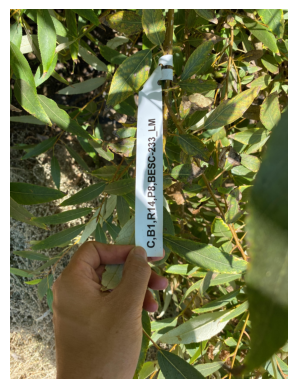

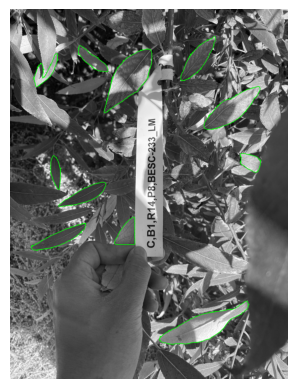

{'area_peri': 0.018395274152371268,
 'area_rect': 0.3920508538490546,
 'area_convex': 0.8901615041758199,
 'area_elli_inter': 0.9390516705965121,
 'ellipse_elli_inter': 0.847923379759076,
 'area_image': 0.014922042312295289,
 'h0': 0.46240825640456235,
 'h1': 1.045062018561765,
 'h2': 2.559385945369376,
 'h3': 2.843302441321813,
 'h4': 5.547335965109052,
 'h5': 3.4276616902501678,
 'h6': 6.499544985997159,
 'col_h': 129.2770059370498,
 'col_s': 177.704080630375,
 'col_v': 167.32971908150347}

In [15]:
# extract features from the contour
def get_features_mask(contour: cv2.Contour, img: cv2.Image) -> dict[str, float]:

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(contour))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(contour, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(contour))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(contour)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [contour], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    area_intersect_ratio = total_merged_area / area
    area_ellipse_intersect_ratio = total_merged_area / ellipse_area

    # get average color - in hsv
    drawn_contour = cv2.drawContours(np.zeros(img.shape[:2], dtype=np.uint8), [contour], -1, (255), cv2.FILLED)
    mean = cv2.mean(img, mask=drawn_contour)
    avg_colors = {
        label: col_val for label, col_val
        in zip(['col_h', 'col_s', 'col_v'], mean)
    }

    # get ratio of contour area to area of whole image
    area_imagearea_ratio = area / float(np.prod(img.shape[:2]))

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio,
        'area_image': area_imagearea_ratio
    } | moment_dict | avg_colors

# read contours from the image
def load_contours(img: cv2.Image, mask: cv2.Image, show: bool = False) -> list[cv2.Contour]:
    
    # find contours from the mask
    edged = cv2.Canny(mask, threshold1=0, threshold2=0)
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # filter away ones that are too small
    contours = [*filter(lambda cnt: cv2.contourArea(cnt) > float(np.prod(img.shape[:2])) / 1000, contours)]

    if show:
        drawn_contours = draw_contours(contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
        imshow(drawn_contours)
    
    return contours

filename = '5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg'
img = get_image(filename)
mask = cv2.imread(f"{SAM_DATA_PATH}/{filename}", cv2.IMREAD_GRAYSCALE)

contour = load_contours(img, mask, show=True)[0]
get_features_mask(contour, img)

Load ML model to further filter the contours

5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg


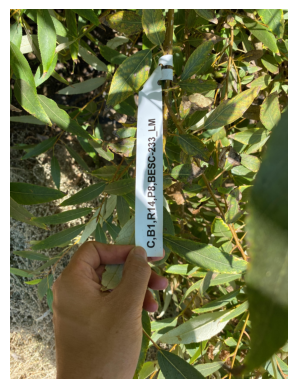

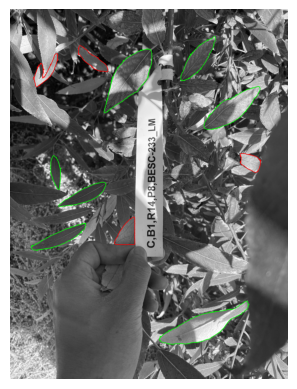

In [16]:
def load_models() -> tuple[RandomForestClassifier, StandardScaler]:
    with open(f"{SAM_PATH}/model.pkl", "rb") as f:
        model = pickle.load(f)
    with open(f"{SAM_PATH}/scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    return model, scaler

def load_contours(img: cv2.Image, mask: cv2.Image, show: bool = False) -> list[cv2.Contour]:
    
    # find contours from the mask
    edged = cv2.Canny(mask, threshold1=0, threshold2=0)
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # filter away ones that are too small
    contours = [*filter(lambda cnt: cv2.contourArea(cnt) > float(np.prod(img.shape[:2])) / 1000, contours)]

    if show:
        drawn_contours = draw_contours(contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
        imshow(drawn_contours)
    
    return contours

def get_real_leaves(img: cv2.Image, filename: str, model: 
                    RandomForestClassifier, scaler: StandardScaler) -> tuple[list[cv2.Contour]]:
    
    PREDICTION_THRESH = 0.50

    # convert masks to be an image
    if filename in os.listdir(SAM_DATA_PATH):
        mask_image = cv2.imread(f"{SAM_DATA_PATH}/{filename}", cv2.IMREAD_GRAYSCALE)
    else:
        masks = get_masks(img, predictor, ort_session)
        mask_image = masks_to_image(masks)

        # kinda cache that image into the folder
        cv2.imwrite(f"{SAM_DATA_PATH}/{filename}", mask_image)

    # get prediction of leaf or not
    contours = load_contours(img, mask_image)
    feature_list = [*map(lambda cnt: get_features_mask(cnt, img), contours)]
    scaled_features = scaler.transform(pd.DataFrame(feature_list))
    probabilities = model.predict_proba(scaled_features)

    # filter predictions
    good_leaves, bad_leaves = [], []
    for contour, (_, prob_leaf) in zip(contours, probabilities):
        if prob_leaf > PREDICTION_THRESH:
            good_leaves.append((contour, prob_leaf))  # is going to be sorted as well
        else:
            bad_leaves.append(contour)
    
    # sort good leaves on accuracy
    good_leaves = [i[0] for i in sorted(good_leaves, reverse=True, key=lambda x: x[1])]

    return good_leaves, bad_leaves

model, scaler = load_models()
filename = '5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg'
img = get_image(filename)
good_leaves, bad_leaves = get_real_leaves(img, filename, model, scaler)
drawn_contours = draw_contours(good_leaves, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
drawn_contours = draw_contours(bad_leaves, drawn_contours, mode="red")
imshow(drawn_contours)

For each good contour, crop it and produce and image of a leaf

EF28FB4A-91B9-4543-B021-6DEE9937B03E.jpg


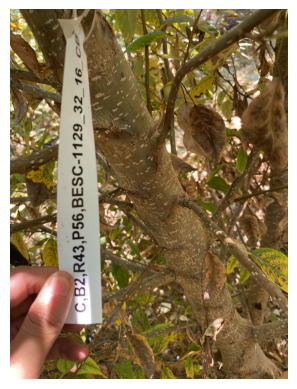

IndexError: list index out of range

In [23]:
def crop_final_leaves(img: cv2.Image, filename: str,
                     model: RandomForestClassifier, scaler: StandardScaler) -> list[cv2.Image]:
    
    EXTRA_SPACE_FACTOR = 0.3
    
    final_leaves, _ = get_real_leaves(img, filename, model, scaler)
    image_h, image_w = img.shape[:2]

    leaves = []
    for leaf in final_leaves:

        # detremine bounds and angle
        x, y, w, h = cv2.boundingRect(leaf)
        _, _, angle = cv2.minAreaRect(leaf)
        
        # adjust bounds based on extra space wanted
        y_min = max(0, round(y-h*EXTRA_SPACE_FACTOR))
        x_min = max(0, round(x-w*EXTRA_SPACE_FACTOR))
        y_max = min(image_h, round(y+h*(1 + EXTRA_SPACE_FACTOR)))
        x_max = min(image_w, round(x+w*(1 + EXTRA_SPACE_FACTOR)))
        
        # crop the image and generate a leaf mask
        cropped_img = img[y_min:y_max, x_min:x_max]
        leaf_mask = cv2.drawContours(
            image=np.zeros((y_max-y_min, x_max-x_min), dtype=np.uint8),
            contours=[leaf - [x_min, y_min]],
            contourIdx=-1, color=255, thickness=cv2.FILLED
        )

        # add the leaf, rotate it, and return whole thing
        leaf_only = cv2.bitwise_and(cropped_img, cropped_img, mask=leaf_mask)
        leaves.append(imutils.rotate_bound(leaf_only, angle=-angle-90))
    
    return leaves

model, scaler = load_models()
filename = '5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg'
img = get_image(filename)
final_leaves = crop_final_leaves(img, filename, model, scaler)
imshow(final_leaves[0])

@Langa, here's what you can do with the leaves

- use get_final_leaves(img, filename, model, scaler) to get the images of the leaves
    - then you can run the leaves into your model
        - i'll run something to turn the leaves into a folder
    - or. i can make something that gets you only one leaf
        - you're gonna need to subjectively determine morphologies
            - i suggest making a spreadsheet, copying the filename into one col, and the morph into the other
                - do this for 50-100 leaf images, make sure to have nice variety
                - to do this, you can run the get_final_leaves definition cell to repeatedly generate random ones (when all the masks are loaded)
    - im gonna work on step3, you need to have your model soon

In [31]:
random.seed(100)
model, scaler = load_models()
filenames = {*random.choices(os.listdir(SAM_DATA_PATH), k=50)}
image_dict = {
    "filename": [],
    "img": [],
    "contour": []
}
for filename in filenames:
    img = get_image(filename, show=False)
    try:
        masked_image = crop_final_leaves(img, filename, model, scaler)[0]
        gray = grayscale(masked_image)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contour = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]

        print(filename)
        image_dict['filename'].append(filename)
        image_dict['img'].append(masked_image)
        image_dict['contour'].append(contour)
    except:
        continue

5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg
2728FC13-5EE5-4979-B800-8748EF0FF6E1.jpg


In [32]:
dataframe = pd.DataFrame({'area_peri',
        'area_rect',
        'area_convex',
        'area_elli_inter',
        'ellipse_elli_inter',
        'area_image'})

print(image_dict)
for i in range(len(image_dict['filename'])):
    features = get_features_mask(image_dict['contour'][i], image_dict['img'][i])
    dataframe.append(features)

{'filename': ['5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg', '2728FC13-5EE5-4979-B800-8748EF0FF6E1.jpg'], 'img': [array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],

TypeError: get_features_mask() missing 1 required positional argument: 'img'

In [27]:
imaginary_data = pd.DataFrame({
    "feature1": [1, 2, 3],
    "feature2": [4, 5, 6],
    # ...
    "class1": ['green', 'yellow', 'green'],
    "class2": ['thin', 'circular', 'wavy']
})


{'5A7143DA-EC14-4F0C-ADBA-78B3D85B8CC2.jpg': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 '2728FC13-5EE5-4979-B800-8748EF0FF6E1.jpg': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
  